# **Crop Disease Classification [Tomato]**

#### **Import libraries and packages** 

In [35]:
import os
import random 
import glob
#import wandb
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns 
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from typing import Dict, Tuple, List
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.optim as optim
import torchinfo 
import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

# data dir 
ROOT_DIR = 'dataset'

In [2]:
base = nn.Identity()
base

Identity()

In [3]:
# setting up device 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


____________________________

### **Custom Dataset**

Creating a custom dataset class like the one implemented offers several benefits:

- **Customization**: You can tailor the dataset class to suit your specific project requirements. This includes handling data loading, preprocessing, augmentation, and organizing the data structure in a way that fits your model's input format.

- **Flexibility**: With a custom dataset class, you have the flexibility to incorporate different transformations, resizing options, and data augmentation techniques. This enables experimentation and fine-tuning of data preprocessing for optimal model training.

- **Code Reusability**: Once you have a well-defined custom dataset class, you can reuse it across different projects or experiments. This promotes code modularity and reduces redundancy in data loading and preprocessing code.

- **Integration with PyTorch**: By inheriting from `torch.utils.data.Dataset`, your custom dataset class seamlessly integrates with PyTorch's data loading utilities like `DataLoader`. This makes it easy to use your dataset in training loops and other PyTorch workflows.

- **Efficient Data Handling**: Custom dataset classes allow for efficient data handling, including lazy loading of images, on-the-fly data augmentation, shuffling, batching, and parallel data loading using multiprocessing.

- **Organized Data Management**: The dataset class organizes data paths, labels, class names, and other metadata in a structured manner, making it easier to access and manage data during training and evaluation.

- **Scalability**: The class design can scale to handle large datasets without overwhelming system memory, thanks to features like lazy loading and efficient batch processing.

Overall, creating a custom dataset class enhances code modularity, flexibility, and scalability, leading to more manageable and effective deep learning workflows.


In [4]:
# CustomDataset class for multi-class image classification
class CustomDataset(Dataset):
    
    
    def __init__(self, root_dir: str, split: str, transform=None, resize=None):
        """
        Custom dataset class for multi-class image classification.

        Args:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.

        Attributes:
            root_dir (str): Root directory containing the dataset.
            split (str): Split (e.g., train, validation) of the dataset.
            transform (callable, optional): Optional transformation to apply to the data.
            resize (int, optional): Resize dimensions (width, height) for the images.
            data (list): List of image paths.
            targets (list): List of target labels.
            class_names (list): List of class names.
            class_idx_to_name (dict): Dictionary mapping class indices to class names.
    
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []
        

        # Determine the data directory based on the split
        data_dir = os.path.join(root_dir, split)

        # Walk through the class subfolders
        class_dirs = sorted(os.listdir(data_dir))  
        for class_idx, class_dir in enumerate(class_dirs):  
            class_path = os.path.join(data_dir, class_dir)  
            self.class_names.append(class_dir)  

            # Walk through the images in each class subfolder
            for img_name in os.listdir(class_path):  
                img_path = os.path.join(class_path, img_name)  
                self.data.append(img_path)  
                self.targets.append(class_idx)  
        # Create a dictionary to map class indices to class names
        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}
        # Method to get the length of the dataset
    def __len__(self):
        """
        Get the length of the dataset.

        Returns:
            int: The number of images in the dataset.
        """
        return len(self.data)

    # Method to get a specific item from the dataset
    def __getitem__(self, idx):
        """
        Get a specific item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the processed image and its target label.
                If an error occurs during image loading or processing, returns (None, None).
        """
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize is not None:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform is not None:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None
    
    def num_classes(self):
        """
        Get the number of classes in the dataset.

        Returns:
            int: Number of classes.
        """
        return len(self.class_names)

    
    def get_class_name(self, class_idx):
        """
        Get the class name based on its index.

        Args:
            class_idx (int): Index of the class.

        Returns:
            str: The name of the class.
        """
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        """
        Get all class names in the dataset.

        Returns:
            list: A list of class names.
        """
        return list(self.class_idx_to_name.values())

    def class_idx_to_name_dict(self):
        """
        Get a dictionary mapping class indices to class names.

        Returns:
            dict: A dictionary mapping class indices to class names.
        """
        return self.class_idx_to_name



    def get_class_frequencies(self):
        """
        Calculate and return a dictionary containing the number of samples for each class.

        Returns:
            dict: A dictionary with class indices as keys and sample counts as values.
        """
        class_counts = {}
        for label in self.targets:
            if label not in class_counts:
                class_counts[label] = 0
            class_counts[label] += 1
        return class_counts
    
    ### ADD ANY ADDITIONAL METHODS  

#### Example of Functionalities of `CustomDataset` class . 

_____________________

### **Image Augmentation and Normalization**

The **Augmentation** pipeline is a series of techniques applied to training images to increase the dataset size artificially and improve the robustness of your image classification model. By introducing controlled variations of the original images, the model learns to generalize better to unseen data and reduces the risk of overfitting.

- **Horizontal Flip** (p=0.5): Randomly flips the image horizontally with a probability (p) of 0.5. This helps the model recognize objects regardless of their orientation.

- **Vertical Flip** (p=0.3): Similar to horizontal flip but flips vertically with a probability of 0.3. Makes the model invariant to objects appearing upside down.

- **Random Rotate90** (p=0.3): Rotates the image by 0, 90, 180, or 270 degrees with a probability of 0.3. Enhances the model's ability to classify objects at different rotations.

- **RandomBrightnessContrast** (p=0.3): Randomly adjusts brightness (-0.2 to 0.2) and contrast (-0.3 to 0.3) with a probability of 0.3. Improves model performance under varying lighting conditions.

- **HueSaturationValue** (p=0.2): Randomly shifts hue (color), saturation (color intensity), and value (brightness) within specified limits with a probability of 0.2. Makes the model less sensitive to color variations.

- **GaussNoise** (p=0.1): Injects random Gaussian noise with varying intensity (10 to 50) with a probability of 0.1. Simulates noisy images and helps the model handle imperfections.

- **CLAHE** (p=0.2): Applies Contrast Limited Adaptive Histogram Equalization (CLAHE) to improve local contrast in images with a probability of 0.2. Can be useful for enhancing details in low-contrast images.

- **CenterCrop** (height=224, width=224, p=0.3): Randomly crops a central square of size 224x224 from the image with a probability of 0.3. Helps the model focus on the most relevant parts of the image and reduces the impact of irrelevant surroundings.

- **Normalize** (mean, std): Normalizes pixel values to a common range (usually between 0 and 1) using predefined mean and standard deviation values. This is crucial for many deep learning models to function properly. (**When using pre-trianed models use mean and std mentioned in a the model description**)

- **ToTensorV2**(): Converts the image data from a NumPy array to a PyTorch tensor format, which is the expected input format for most deep learning frameworks.

Note : When selecting augmentation methods and parameters, especially in domains where preserving critical information is essential, such as agriculture or medical imaging, it's crucial to prioritize the preservation of key details. Carefully choose augmentation techniques that enhance dataset diversity without distorting or losing important information like disease or pest features. Adjust parameters cautiously to ensure that critical details remain intact throughout the augmentation process. By prioritizing information preservation in augmentation, you can build more robust and accurate models that generalize well to real-world scenarios.

#### **Benefits of Augmentation :**

1. **Increased Dataset Size**: Creates new variations of existing images, effectively expanding the training data without needing to collect more images.

2. **Improved Generalization**: Forces the model to learn features that are common across different variations of the same object, leading to better performance on unseen data.

3. **Reduced Overfitting**: Prevents the model from memorizing specific details of the training images and instead focuses on capturing more generalizable features.

4. **Enhanced Robustness**: Makes the model less sensitive to noise, lighting variations, and other factors that might affect image appearance in real-world scenarios.

In [42]:
def get_transforms(config:Dict, augment:bool = True):
    """
    Get data augmentation and transformation pipelines for image data.

    Args:
        augment (bool, optional): Whether to apply data augmentation. Default is True.

    Returns:
        tuple: A tuple containing the training and validation transformation pipelines.

    Notes:
        - If augment is True, applies a set of augmentation techniques including horizontal flip, vertical flip,
          random rotation, random brightness/contrast adjustments, hue/saturation/value adjustments, noise addition,
          CLAHE, and normalization with specified mean and standard deviation.
        - If augment is False, applies only normalization with specified mean and standard deviation.

    Example:
        train_transform, valid_transform = get_transforms(augment=True)
    """
    if augment:
        train_transform  = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=(-0.15,0.15), contrast_limit=(-0.15, 0.15), p=0.3),
            #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.2),
            A.GaussNoise(var_limit=(10, 50), p=0.1),
            A.CLAHE(clip_limit=(1,3), tile_grid_size=(8, 8), p=0.3),
            #A.RandomCrop(224, 224, 0.3),  # RandomCrop to introduce variability
            A.CenterCrop(height=config['crop'], width=config['crop']),  # CenterCrop to focus on central area
            # choose mean and std based on pre-trained model specification.
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
            ])
    else:
        train_transform = A.Compose([
            A.CenterCrop(height=config['crop'], width=config['crop']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    
    valid_transform = A.Compose([
            A.CenterCrop(height=config['crop'], width=config['crop']),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
    
    return train_transform, valid_transform
        

### **Training Loop**

The `training_model` method trains a given model on a training dataset using a provided optimizer and loss function.
- It takes the following parameters:
  - `model`: The model to be trained.
  - `dataloader`: The DataLoader for the training dataset.
  - `optimizer`: The optimizer used to update the model parameters.
  - `loss_fn`: The loss function used to calculate the loss.
  - `device`: The device (e.g., GPU or CPU) to use for training.
- Within the method, the model is set to training mode (`model.train()`) to enable dropout and batch normalization layers.
- It iterates through the training DataLoader, performing the following steps for each batch:
  - Sends the batch of images and labels to the specified device.
  - Computes the predictions using the model (`y_pred`).
  - Calculates the loss between predictions and actual labels.
  - Performs backward propagation (`loss.backward()`) and updates model parameters (`optimizer.step()`).
- During training, it accumulates loss and accuracy metrics.
- After iterating through the dataset, it calculates the average loss and accuracy.
- Evaluation metrics such as precision, recall, and F1 score (macro) are computed using scikit-learn metrics functions.
- The method returns a dictionary containing the calculated training results, including loss, accuracy, precision, recall, and F1-score.

In [24]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    """ 
    Trains a model on a given dataset using a specified optimizer and loss function.

    Args:
        model (torchvision.models): The model to be trained.
        dataloader (DataLoader): The data loader for the training dataset.
        optimizer (optim.Optimizer): The optimizer used to update the model parameters.
        loss_fn (nn.Module): The loss function used to calculate the loss.
        device (torch.device): The device (e.g., GPU or CPU) to use for training.

    Returns:
        dict: A dictionary containing the training results, including the average loss, accuracy, precision, recall, and F1-score.
    """
    
    # Set the model to training mode
    model.train()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Loop over the data
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss and correct predictions
        running_loss += loss.item() * images.size(0)
        running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed training results
    training_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    return training_results


### **Validation Loop**  

The `validation_model` method evaluates the performance of a model on a validation dataset.

- It takes the following parameters:
  - `model`: The model to be evaluated.
  - `dataloader`: DataLoader for the validation dataset.
  - `loss_fn`: Loss function to evaluate the model's performance.
  - `device`: Device to perform computations on (e.g., 'cpu' or 'cuda').
- During evaluation, the model is set to evaluation mode (`model.eval()`) to disable dropout and batch normalization layers.
- It iterates through the validation DataLoader, computing predictions and accumulating loss and accuracy.
- Additionally, it collects true and predicted labels for further evaluation metrics.
- After iterating through the dataset, it calculates average loss and accuracy.
- Evaluation metrics such as precision, recall, and F1 score (macro) are calculated using scikit-learn metrics functions.
- The function returns a dictionary containing the computed evaluation metrics.

In [25]:
def validate_model(model, dataloader, loss_fn, device):
    """ 
    Evaluates the model on a validation dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
        loss_fn (torch.nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations on (e.g., 'cpu' or 'cuda').

    Returns:
        dict: A dictionary containing the average loss, accuracy, precision, recall, and F1 score (macro).
    """

    # Set the model to evaluation mode
    model.eval()

    # Initialize running totals for loss and correct predictions
    running_loss = 0.0
    running_corrects = 0
    true_labels, predicted_labels = [], []

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Loop over the data
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Accumulate loss and correct predictions
            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(dim=1) == labels).sum().item()

            # Collect true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(outputs.argmax(dim=1).cpu().numpy())

    # Calculate average loss and accuracy over the entire dataset
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Return detailed validation results
    validation_results = {
        'Loss': epoch_loss,
        'Accuracy': epoch_acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Macro': f1,
    }

    # Reset the model to training mode
    model.train()

    return validation_results

### **Model Training Pipeline**

#### **Early Stopping**

The `EarlyStopping` class is designed to halt the training of a machine learning model when the validation loss has stopped improving. It helps to prevent overfitting by monitoring the validation loss and stopping the training process if no improvement is observed for a specified number of epochs (patience).

**Key Parameters**:
- **patience**: Number of epochs to wait for improvement before stopping the training.
- **min_delta**: Minimum change in validation loss to qualify as an improvement.
- **restore_best_weights**: Whether to restore the model weights to the best observed state before stopping.

**Main Methods**:
- `__init__(self, patience=5, min_delta=0, restore_best_weights=True)`: Initializes the early stopping mechanism with the given parameters.
- `__call__(self, model, val_loss)`: Checks if the validation loss has improved. If not, it increments the counter and potentially triggers early stopping. If early stopping is triggered, it can restore the best model weights observed during training.

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

#### **Training Pipeline**

The `training_pipeline` method oversees the training and validation process of a image classification model.
- It accepts the following parameters:
  - Configuration dictionary (`config`)
  - Model (`model`)
  - DataLoaders for training and validation datasets (`train_loader`, `valid_loader`)
  - Optimizer (`optimizer`)
  - Loss function (`loss_fn`)
  - Computation device (`device`)

- The function operates over a specified number of epochs, performing the following steps in each epoch:
  - Trains the model using the training DataLoader.
  - Evaluates the model's performance using the validation DataLoader.
  - Tracks and updates the best validation F1 score and the corresponding model state.

- Upon completion of all epochs:
  - Saves the model state with the best validation F1 score.
  - Prints training and validation results for each epoch, providing detailed performance logs.


In [9]:

def training_pipeline(config:Dict,
                      model:models, 
                      train_loader:DataLoader,
                      valid_loader:DataLoader,
                      optimizer:optim.Optimizer,
                      loss_fn:nn.Module,
                      early_stopping:None,
                      device:str):
    """ 
    Function to manage the training pipeline of a machine learning model.

    Args:
        config (Dict): A dictionary containing configuration parameters, including the number of epochs.
        model (torchvision.models): The model to be trained.
        train_loader (DataLoader): DataLoader for the training dataset.
        valid_loader (DataLoader): DataLoader for the validation dataset.
        optimizer (optim.Optimizer): Optimizer for model parameter updates.
        loss_fn (nn.Module): Loss function to evaluate the model's performance.
        device (str): Device to perform computations (e.g., 'cpu' or 'cuda').

    Returns:
        None
    """
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_f1': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }
    best_val_f1 = 0.0
    best_model_state_dict = None

    for epoch in tqdm(range(config['epochs'])):
        print(f'Epoch {epoch + 1}/{config["epochs"]}')
        print('-' * 10)
        
        train_res = train_model(model=model, 
                                dataloader=train_loader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)
            
        print(f"Train - Loss: {train_res['Loss']:.4f}, Accuracy: {train_res['Accuracy']:.4f}, Precision: {train_res['Precision']:.4f}, Recall: {train_res['Recall']:.4f}, F1 Score: {train_res['F1-Macro']:.4f}")

        val_res = validate_model(model=model, 
                                dataloader=valid_loader,
                                loss_fn=loss_fn,
                                device=device)
        print(f"Validation - Loss: {val_res['Loss']:.4f}, Accuracy: {val_res['Accuracy']:.4f}, Precision: {val_res['Precision']:.4f}, Recall: {val_res['Recall']:.4f}, F1 Score: {val_res['F1-Macro']:.4f}")
        
         # Save the results
        history['train_loss'].append(train_res['Loss'])
        history['train_accuracy'].append(train_res['Accuracy'])
        history['train_precision'].append(train_res['Precision'])
        history['train_recall'].append(train_res['Recall'])
        history['train_f1'].append(train_res['F1-Macro'])
        
        history['val_loss'].append(val_res['Loss'])
        history['val_accuracy'].append(val_res['Accuracy'])
        history['val_precision'].append(val_res['Precision'])
        history['val_recall'].append(val_res['Recall'])
        history['val_f1'].append(val_res['F1-Macro'])

        # Check early stopping
        if early_stopping:
            if early_stopping(model, val_res['Loss']):
                print(early_stopping.status)
                break
            else:
                print(early_stopping.status)
                
        # Deep copy the model if it has the best F1 score so far
        if val_res['F1-Macro'] > best_val_f1:
            best_val_f1 = val_res['F1-Macro']
            best_model_state_dict = copy.deepcopy(model.state_dict())
        print()
        
     # # Load best model weights for validation loss (if applicable)
    if early_stopping and early_stopping.restore_best_weights:
        model.load_state_dict(early_stopping.best_model)
    else:
        model.load_state_dict(best_model_state_dict)  

    # Save the best model after after training and validation 
    if best_model_state_dict is not None:
        torch.save(best_model_state_dict, os.path.join('artifacts', config['weights_path']))
    
    return history


#### **Plot training results**

In [10]:
def plot_training_results(history):
  """
  Plot training and validation loss and F1-score from training history.

  Args:
      history (Dict): Dictionary containing training and validation results for each epoch.
          Expected keys: 'train_loss', 'val_loss', 'train_f1', 'val_f1'
  """
  plt.figure(figsize=(20, 12))

  # Plot loss
  plt.subplot(2, 1, 1)
  plt.plot(history['train_loss'], label='Train Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  # Plot F1-score
  plt.subplot(2, 1, 2)
  plt.plot(history['train_f1'], label='Train F1-Score')
  plt.plot(history['val_f1'], label='Validation F1-Score')
  plt.xlabel('Epoch')
  plt.ylabel('F1-Score')
  plt.title('Training and Validation F1-Score')
  plt.legend()

  plt.tight_layout()
  plt.show()

### **Evaluation** 

The `evaluate_model` method assesses the performance of a machine learning model using a test dataset.
- It takes the following parameters:
  - `model`: The trained model to be evaluated.
  - `test_loader`: DataLoader for the test dataset.
- Within the method, the model is set to evaluation mode (`model.eval()`) to disable dropout and batch normalization layers.
- It iterates through the test DataLoader, computing predictions and accumulating true and predicted labels.
- After iterating through the dataset, it computes the confusion matrix (`cm`) and F1 score (macro) using scikit-learn metrics functions.
- The method returns the confusion matrix and F1 score (macro) as evaluation metrics.

In [36]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    # Additional per-class evaluation (optional)
    class_report = classification_report(y_true, y_pred)

    return cm, f1_macro, precision, recall, accuracy, class_report

**Plotting Confusion Matrix**

In [12]:
def plot_cm(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(20,15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Set3',xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


______________

### **Model Evaluation Without Augmentation**

In [13]:
# tweak these and experiment with different values. 
config = dict(
    resize =256 ,
    crop = 240,
    augment= False,
    epochs = 50, 
    batch_size = 32,
    lr = 0.001,
    dropout = 0.2, 
    weights_path = 'weights_basic_ef_b1.pth'
)


In [14]:
es = EarlyStopping(patience=5, min_delta=0.01, restore_best_weights=False)

#### **DataLoader Creation**

We initialize train and validation datasets using custom dataset class (`CustomDataClass`).  `train_loader` and `valid_loader` objects facilitate efficient data loading and processing during training and validation phases of image classification model.

Benefits of creating DataLoader objects are: 
- **Batch Processing**: DataLoader objects (train_loader and valid_loader) facilitate loading the dataset in batches, enabling efficient processing and utilization of computational resources during training and validation.

- **Data Management and Transformation**: They handle data management tasks such as shuffling and parallel data loading, while also applying data transformations such as resizing and augmentation, ensuring that the input data is properly prepared for training and validation.

In [15]:
# get transforms 
train_transform, valid_transform = get_transforms(augment=config['augment'], config=config)
# dataset 
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation', resize=config['resize'], transform=valid_transform)
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

In [16]:
num_classes = train_dataset.num_classes()
print("No. of Classes : ", num_classes)

No. of Classes :  8


In [17]:
class_map = train_dataset.class_idx_to_name_dict()
print("Class Index to class name map: \n")
class_map

Class Index to class name map: 



{0: 'Bacterial_spot227',
 1: 'Late_blight227',
 2: 'Leaf_Mold227',
 3: 'Septoria_leaf_spot227',
 4: 'Target_Spot227',
 5: 'Tomato_Yellow_Leaf_Curl_Virus227',
 6: 'Two-spotted_spider_mite227',
 7: 'healthy227'}

In [18]:
# class frequencies
class_freq = train_loader.dataset.get_class_frequencies()
class_freq

{0: 1361, 1: 1222, 2: 609, 3: 1133, 4: 899, 5: 3428, 6: 1072, 7: 1017}

In [19]:
total_samples = sum(class_freq.values())
num_classes = len(class_freq)

class_weights = [round(total_samples / (num_classes * class_freq[i]), 4) for i in range(num_classes)]
print(class_weights)

[0.9865, 1.0987, 2.2046, 1.185, 1.4935, 0.3917, 1.2524, 1.3202]


##### **Check class distribution and input images in first batch**

Labels: tensor([2, 3, 5, 7, 1, 1, 5, 4, 5, 0, 1, 5, 3, 0, 0, 5, 5, 5, 6, 2, 5, 6, 5, 7,
        1, 1, 0, 2, 5, 0, 4, 0])


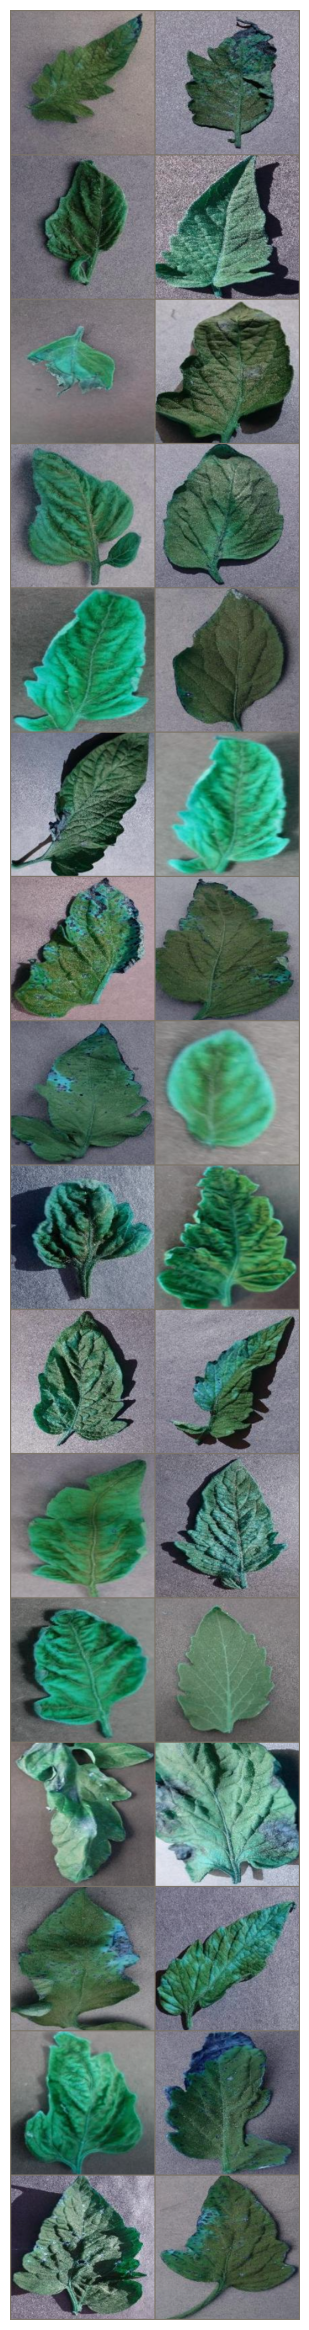

In [20]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader: 
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

### **Model Training and Evaluation**

#### **Model With Pre-trained Weights**

Initialize a [ResNet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) model (`resnet18`) with pre-trained weights from the ImageNet dataset.
- **Parameter freezing**: It freezes the pre-trained model parameters by setting `requires_grad` to False for all parameters, preserving the pre-trained knowledge.
- **Modification of the last layer**: The last fully connected layer (`resnet18.fc`) is modified to adapt the model to the specific classification task. It is replaced with a new sequence of layers, including a linear layer, ReLU activation, dropout regularization, and a final linear layer with softmax activation.

In [9]:
# initialise pre-trained weights
weights = models.ResNet18_Weights.IMAGENET1K_V1
# initialize the model
resnet18 = models.resnet18(weights='IMAGENET1K_V1', progress=True)
# Freeze the pre-trained model parameters
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(in_features=512, out_features= num_classes),
    nn.Softmax(dim=1)
)

# Move the model to the specified device
resnet18 = resnet18.to(device)

### **EfficientNet_B1**

In [21]:
model_ef = models.efficientnet_b1(weights='DEFAULT', progress=True)
num_ftrs = model_ef.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef.parameters():
    param.requires_grad = False
model_ef.classifier = nn.Sequential(
                nn.Dropout(p=config["dropout"], inplace=True),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.Dropout(p=config["dropout"]),
                nn.Linear(512, num_classes)
            )
model_ef = model_ef.to(device)

In [22]:
# define optimizer and loss funtion 
optimizer = optim.Adam(params=model_ef.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

#### **Model Training**

In [26]:
history  = training_pipeline(config=config,
                  model = model_ef,
                  train_loader=train_loader,
                  valid_loader=valid_loader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  early_stopping=es,
                  device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 0.4309, Accuracy: 0.8646, Precision: 0.8460, Recall: 0.8230, F1 Score: 0.8332
Validation - Loss: 0.1597, Accuracy: 0.9440, Precision: 0.9291, Recall: 0.9292, F1 Score: 0.9288


Epoch 2/50
----------
Train - Loss: 0.1903, Accuracy: 0.9349, Precision: 0.9202, Recall: 0.9178, F1 Score: 0.9190
Validation - Loss: 0.1347, Accuracy: 0.9552, Precision: 0.9451, Recall: 0.9434, F1 Score: 0.9427
Improvement found, counter reset to 0

Epoch 3/50
----------
Train - Loss: 0.1495, Accuracy: 0.9462, Precision: 0.9326, Recall: 0.9322, F1 Score: 0.9323
Validation - Loss: 0.1169, Accuracy: 0.9597, Precision: 0.9526, Recall: 0.9488, F1 Score: 0.9498
Improvement found, counter reset to 0

Epoch 4/50
----------
Train - Loss: 0.1403, Accuracy: 0.9509, Precision: 0.9394, Recall: 0.9385, F1 Score: 0.9389
Validation - Loss: 0.0945, Accuracy: 0.9642, Precision: 0.9564, Recall: 0.9565, F1 Score: 0.9564
Improvement found, counter reset to 0

Epoch 5/50
----------
Train - Loss: 0

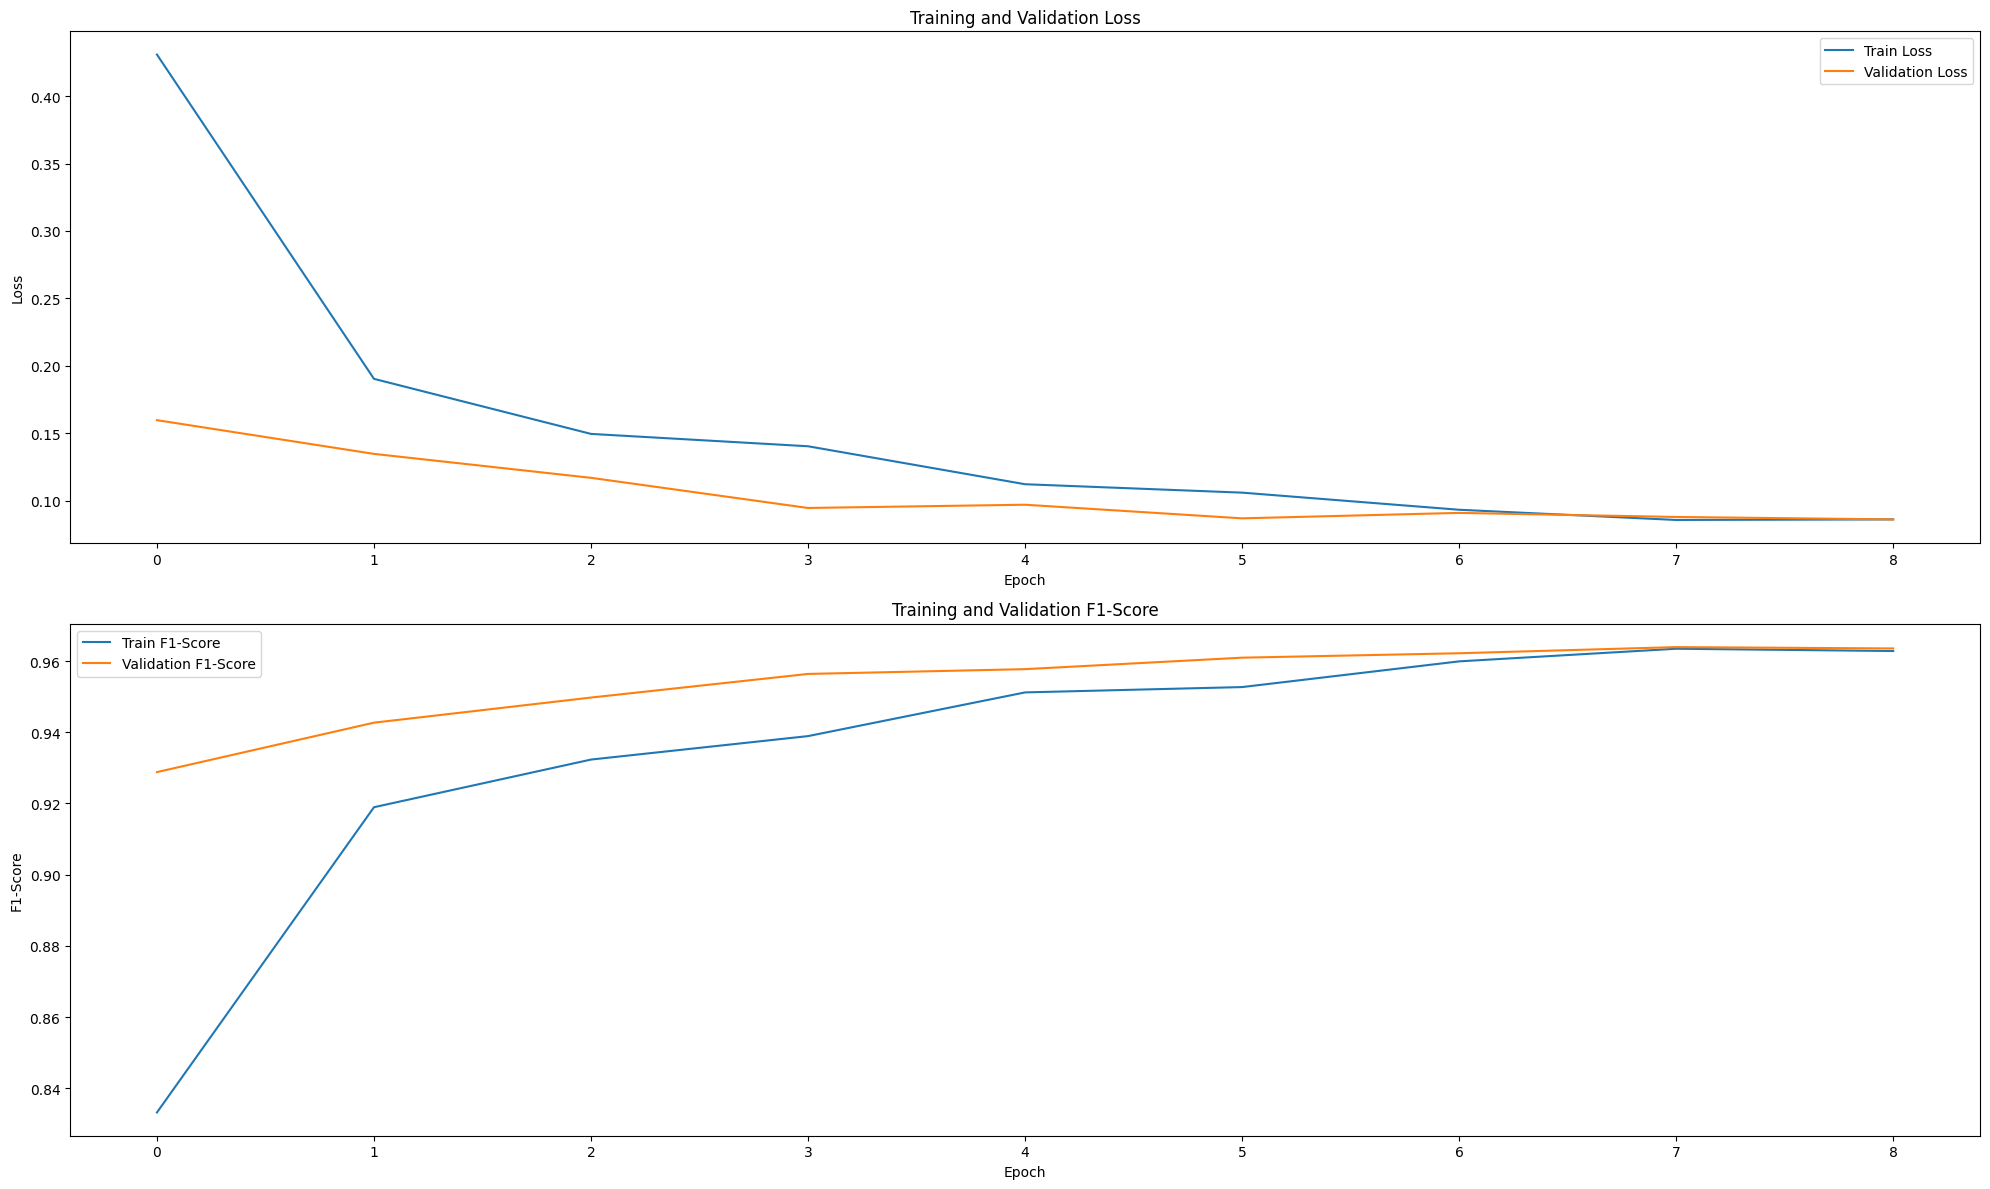

In [27]:
plot_training_results(history=history)

#### **Model Evaluation**

In [28]:
#dataset 
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config['resize'], transform=valid_transform)
# dataloaders
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

In [29]:
class_map = train_dataset.class_idx_to_name_dict()
print(class_map)

{0: 'Bacterial_spot227', 1: 'Late_blight227', 2: 'Leaf_Mold227', 3: 'Septoria_leaf_spot227', 4: 'Target_Spot227', 5: 'Tomato_Yellow_Leaf_Curl_Virus227', 6: 'Two-spotted_spider_mite227', 7: 'healthy227'}


In [30]:
classes = test_dataset.class_names
print(classes)

['Bacterial_spot227', 'Late_blight227', 'Leaf_Mold227', 'Septoria_leaf_spot227', 'Target_Spot227', 'Tomato_Yellow_Leaf_Curl_Virus227', 'Two-spotted_spider_mite227', 'healthy227']


In [31]:
def clean_disease_list(disease_list):
    cleaned_list = [
        item.replace('227', '')
            .replace('Tomato_', '')
            .replace('Tomato', '')
            .replace('-', '_')
            .lower()
        for item in disease_list
    ]
    return cleaned_list

In [32]:
classes = clean_disease_list(classes)
print(classes)

['bacterial_spot', 'late_blight', 'leaf_mold', 'septoria_leaf_spot', 'target_spot', 'yellow_leaf_curl_virus', 'two_spotted_spider_mite', 'healthy']


In [37]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9682, Precision: 0.9603, Recall: 0.9586, F1 Score: 0.9590
Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       171
           1       0.97      0.95      0.96       154
           2       0.92      0.95      0.94        77
           3       0.97      0.96      0.96       143
           4       0.96      0.88      0.92       113
           5       0.99      1.00      0.99       430
           6       0.95      0.96      0.96       135
           7       0.93      1.00      0.97       128

    accuracy                           0.97      1351
   macro avg       0.96      0.96      0.96      1351
weighted avg       0.97      0.97      0.97      1351



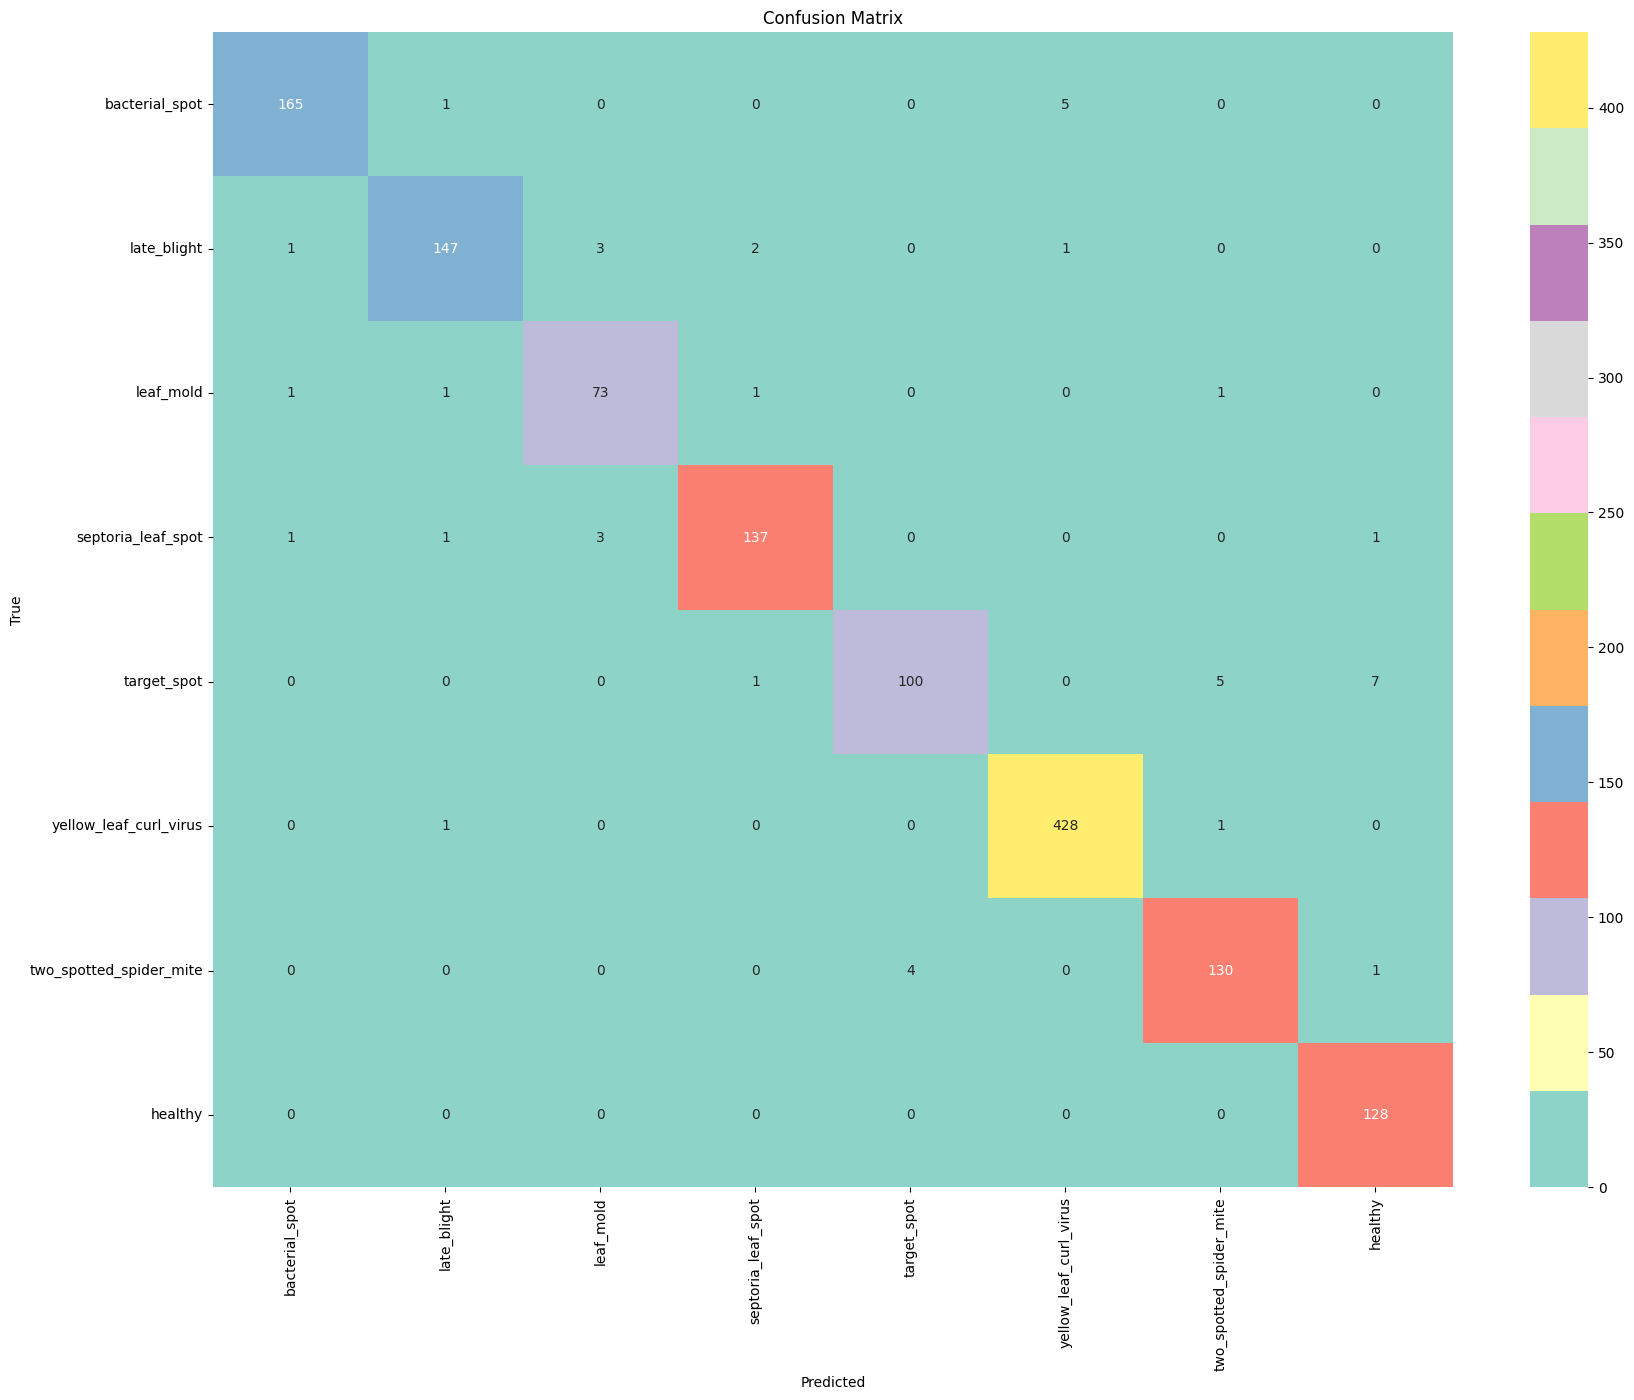

In [38]:
# plot confusion matrix 
plot_cm(cm, classes, title="Confusion Matrix")

_____________________

## **With Augmentation**

In [43]:
# tweak these and experiment with different values. 
config = dict(
    resize =256,
    crop = 240,
    augment= True,
    epochs = 50, 
    batch_size = 32,
    lr = 0.001,
    dropout = 0.3, 
    weights_path = 'weights_aug_ef_b1.pth'
)


#### **DataLoader Creation with augmentation**

In [44]:
# get transforms (augmetnation and normalization)
train_transform, valid_transform = get_transforms(augment=config['augment'], config=config)
# dataset 
train_dataset = CustomDataset(root_dir=ROOT_DIR, split='train',resize=config['resize'], transform=train_transform)
valid_dataset = CustomDataset(root_dir=ROOT_DIR, split='validation',resize=config['resize'], transform=valid_transform)
test_dataset = CustomDataset(root_dir=ROOT_DIR, split='test',resize=config['resize'], transform=valid_transform)
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8)

##### **Check class distribution and input images in first batch**

Labels: tensor([5, 6, 5, 2, 4, 7, 0, 5, 5, 2, 3, 3, 1, 6, 7, 6, 5, 5, 5, 5, 1, 5, 6, 5,
        6, 5, 5, 0, 0, 1, 6, 6])


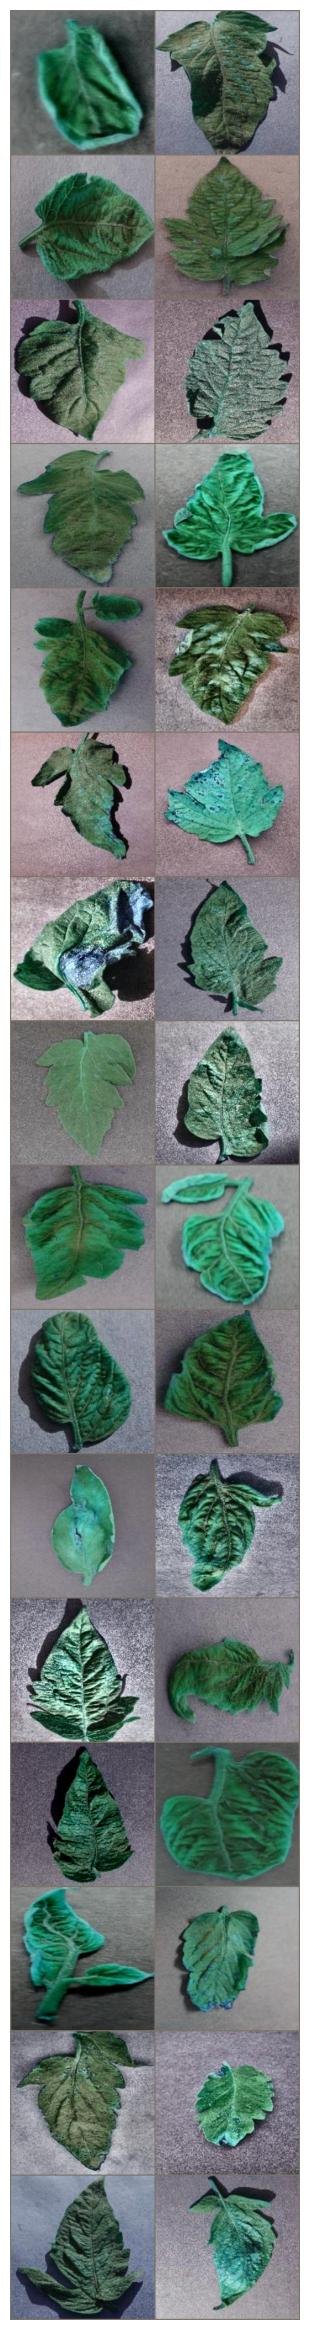

In [45]:
# Fetch the first batch of images and labels from the train_loader
for images, labels in train_loader: 
    break

# Print the labels
print('Labels:', labels)

# Make the grid with 2 rows and 8 columns
im = make_grid(images, nrow=2)  # nrow changed to 8 for 2x8 grid

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Increase the figure size
plt.figure(figsize=(40, 30))  # increased figure size

# Display the images grid
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))
plt.axis('off')  # Turn off axis labels
plt.show()

#### **Model With Pre-trained Weights**

In [34]:
# initialise pre-trained weights
weights = models.ResNet18_Weights.IMAGENET1K_V1
# initialize the model
resnet18 = models.resnet18(weights=weights, progress=True)
# Freeze the pre-trained model parameters
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last fully connected layer
resnet18.fc = nn.Sequential(
    nn.Linear(resnet18.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(config['dropout']),
    nn.Linear(in_features=512, out_features= num_classes),
    nn.Softmax(dim=1)
)

# Move the model to the specified device
resnet18 = resnet18.to(device)

In [35]:
# initialize optimizer and loss function
optimizer = optim.Adam(params=resnet18.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

### **EfficientNet**

In [46]:
model_ef_v1 = models.efficientnet_b1(weights='DEFAULT', progress=True)
num_ftrs = model_ef_v1.classifier[1].in_features
# Freeze the pre-trained model parameters
for param in model_ef_v1.parameters():
    param.requires_grad = False
model_ef_v1.classifier = nn.Sequential(
                nn.Dropout(p=config["dropout"], inplace=True),
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.Dropout(p=config["dropout"]),
                nn.Linear(512, num_classes)
            )
model_ef_v1 = model_ef_v1.to(device)

In [47]:
# initialize optimizer and loss function
optimizer = optim.Adam(params=model_ef_v1.parameters(), lr=config['lr'])
loss_fn = nn.CrossEntropyLoss()

In [48]:
# early stopping 
es = EarlyStopping(patience=10, min_delta=0.01, restore_best_weights=False)

In [50]:
# train and validate model performance and save the model with best evaluation metric. 
history = training_pipeline(config=config,
                  model = model_ef_v1,
                  train_loader=train_loader,
                  valid_loader=valid_loader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  early_stopping=es,
                  device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
----------
Train - Loss: 0.5797, Accuracy: 0.8117, Precision: 0.7841, Recall: 0.7548, F1 Score: 0.7658
Validation - Loss: 0.2135, Accuracy: 0.9321, Precision: 0.9147, Recall: 0.9118, F1 Score: 0.9123


Epoch 2/50
----------
Train - Loss: 0.3198, Accuracy: 0.8894, Precision: 0.8642, Recall: 0.8605, F1 Score: 0.8622
Validation - Loss: 0.1584, Accuracy: 0.9493, Precision: 0.9382, Recall: 0.9346, F1 Score: 0.9359
Improvement found, counter reset to 0

Epoch 3/50
----------
Train - Loss: 0.2747, Accuracy: 0.9018, Precision: 0.8772, Recall: 0.8749, F1 Score: 0.8760
Validation - Loss: 0.1408, Accuracy: 0.9552, Precision: 0.9472, Recall: 0.9411, F1 Score: 0.9437
Improvement found, counter reset to 0

Epoch 4/50
----------
Train - Loss: 0.2567, Accuracy: 0.9087, Precision: 0.8856, Recall: 0.8828, F1 Score: 0.8841
Validation - Loss: 0.1239, Accuracy: 0.9590, Precision: 0.9496, Recall: 0.9489, F1 Score: 0.9491
Improvement found, counter reset to 0

Epoch 5/50
----------
Train - Loss: 0

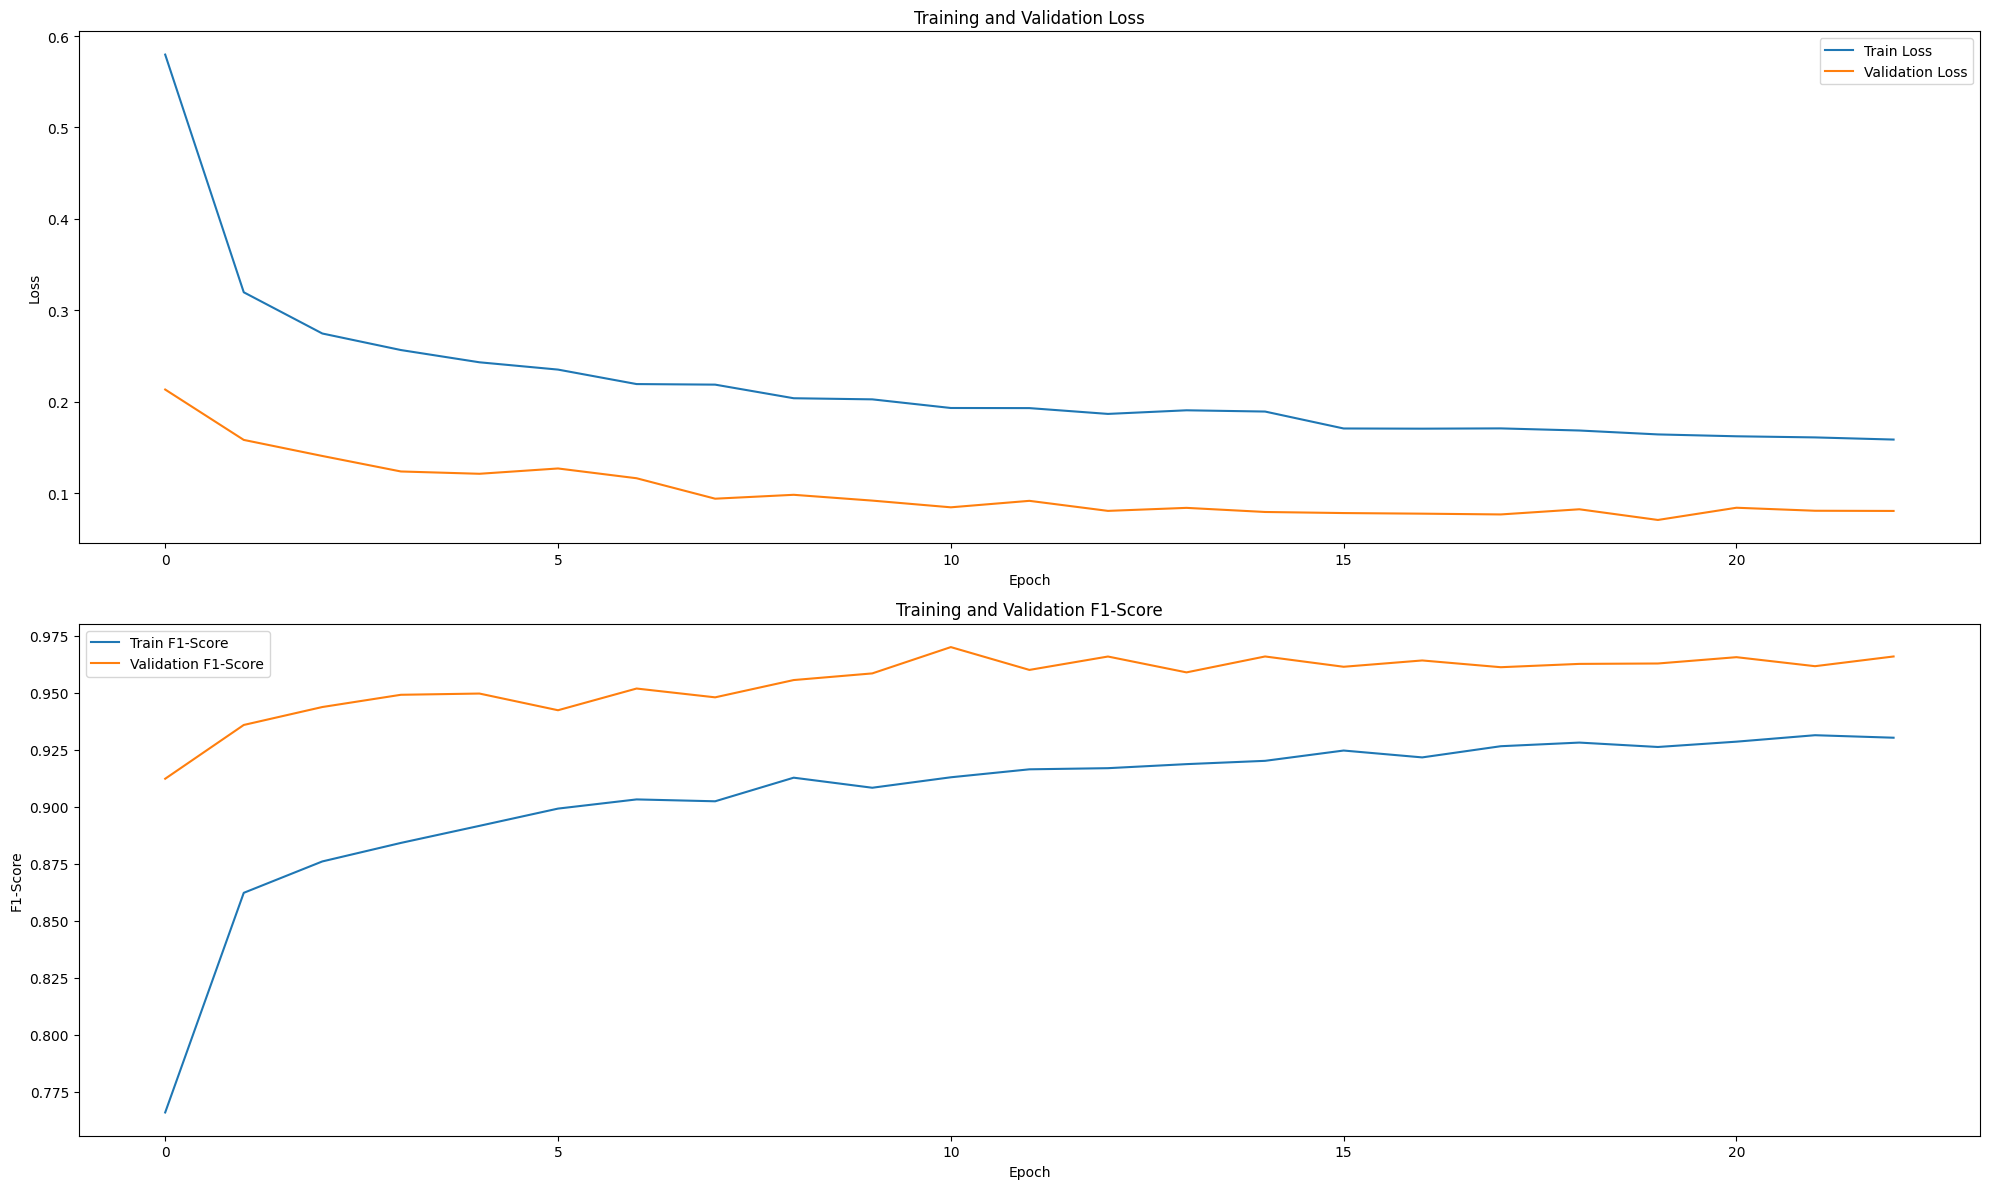

In [52]:
plot_training_results(history=history)

#### **Evaluation on Test dataset**

In [51]:
cm, f1_macro, precision, recall, accuracy, class_report = evaluate_model(model=model_ef_v1, test_loader=test_loader, device='cuda')
print(f"Evaluation Results -  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_macro:.4f}")
print("Classification Report : \n")
print(class_report)

Evaluation Results -  Accuracy: 0.9652, Precision: 0.9597, Recall: 0.9542, F1 Score: 0.9560
Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       171
           1       0.97      0.96      0.96       154
           2       0.99      0.90      0.94        77
           3       0.92      0.99      0.95       143
           4       0.97      0.88      0.92       113
           5       1.00      0.98      0.99       430
           6       0.89      0.98      0.93       135
           7       0.97      0.98      0.97       128

    accuracy                           0.97      1351
   macro avg       0.96      0.95      0.96      1351
weighted avg       0.97      0.97      0.97      1351



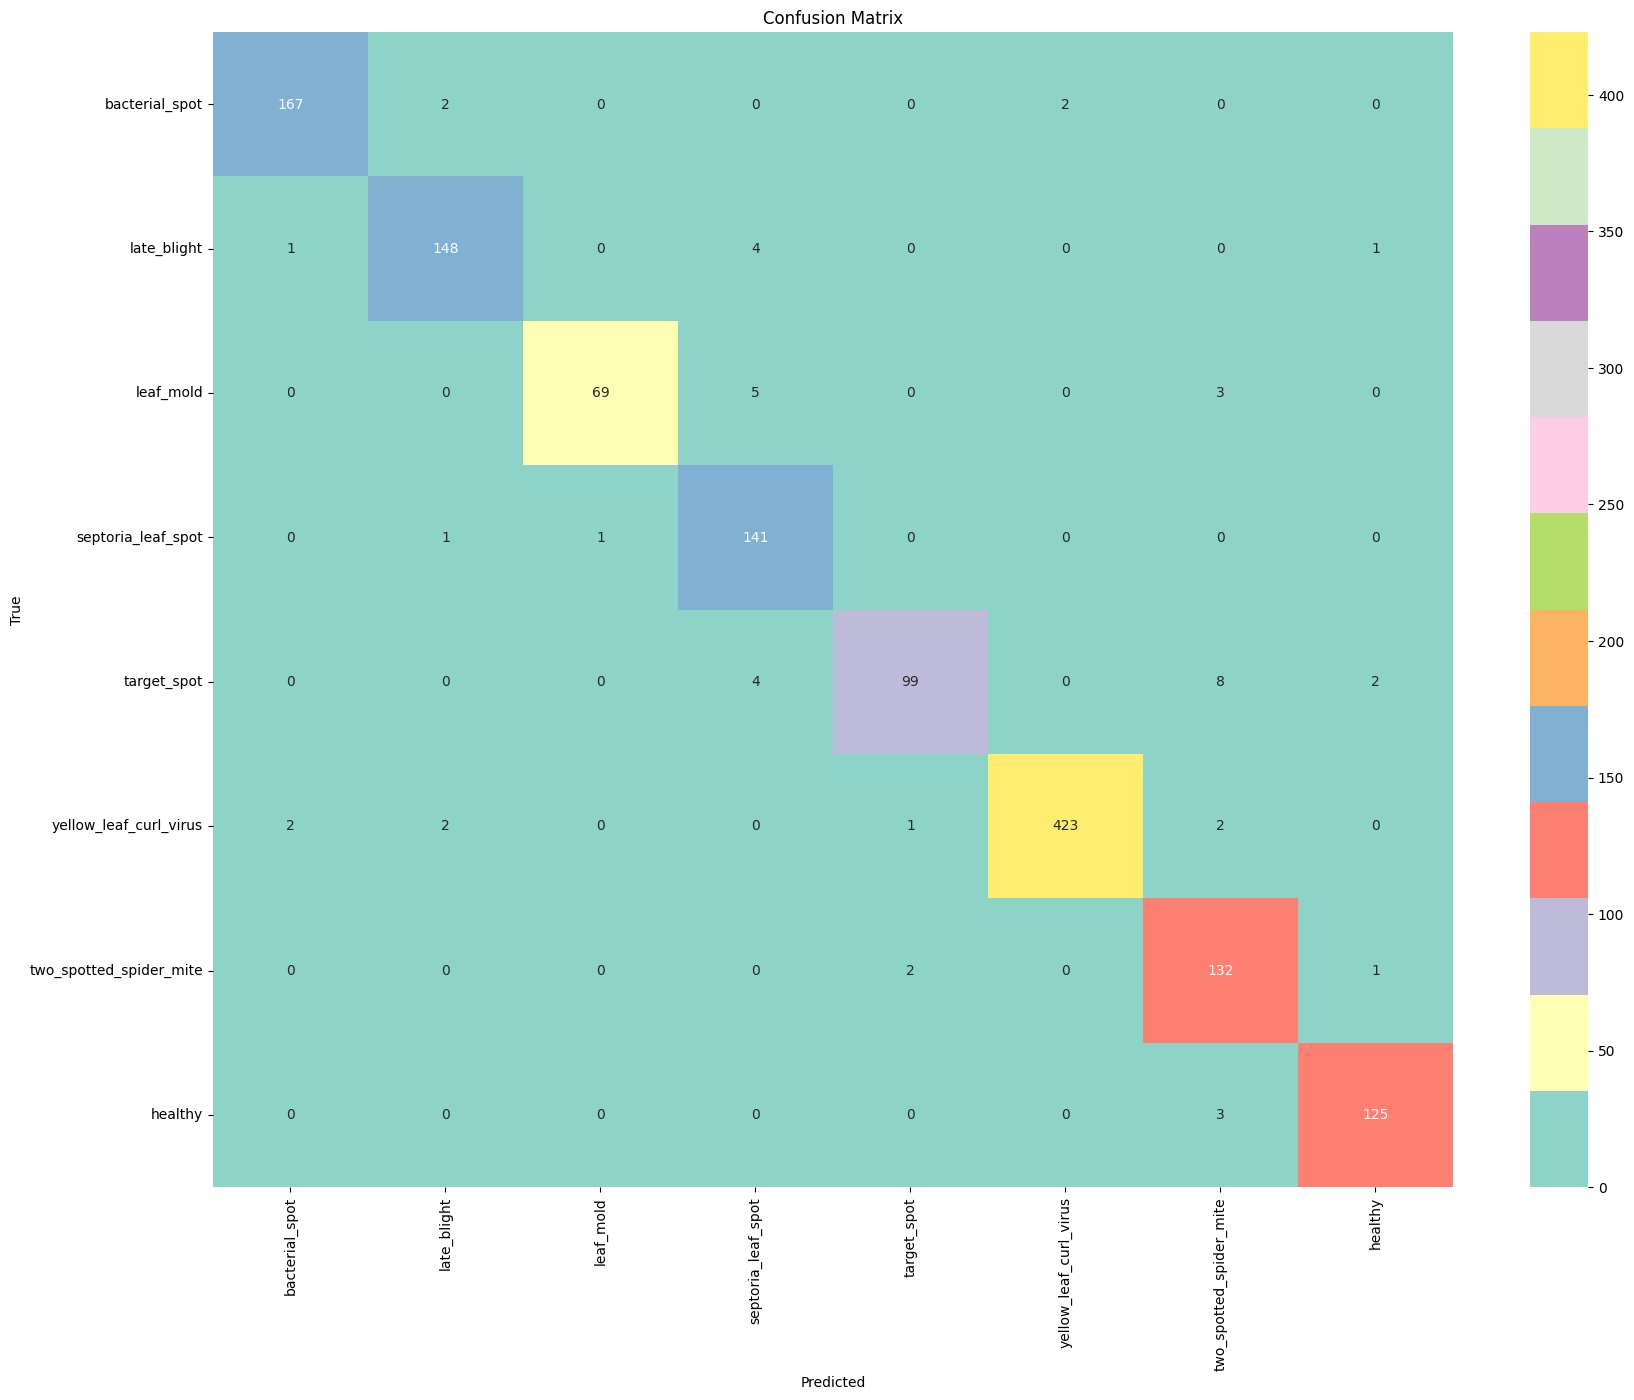

In [53]:
plot_cm(cm,classes=classes)

_______________________________

### **Prediction-Pipeline**

**Load Model with trained weights**

In [57]:
def load_model(weights_path: str, device: str, num_classes: int, config:Dict):
    # Initialize the ResNet18 model with pretrained weights
    model = models.efficientnet_b1(weights=None)
    
    num_ftrs = model.classifier[1].in_features
    # Freeze the pre-trained model parameters
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
                    nn.Dropout(p=config["dropout"], inplace=True),
                    nn.Linear(num_ftrs, 512),
                    nn.ReLU(),
                    nn.Dropout(p=config["dropout"]),
                    nn.Linear(512, num_classes)
                    )
    # Load the saved model weights
    model_weights = torch.load(weights_path)
    model.load_state_dict(model_weights)

    # Set the model to evaluation mode and move it to the specified device
    model.eval().to(device)

    return model


In [104]:
def predict_single_image(image_path, model, device):
    # Load the image
    image = Image.open(image_path)
    
    # Apply transformations
    test_transform = A.Compose([
        A.Resize(height=256, width=256), 
        A.CenterCrop(height=240, width=240),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
       ])
    
    image_tr = test_transform(image=np.array(image))['image']
    image_tr = torch.tensor(image_tr).unsqueeze(0).to(device)

    # Predict the class
    with torch.no_grad():
        outputs = model(image_tr)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the top 2 predicted classes and their probabilities
    top_2_classes = torch.topk(probabilities, 2)

    # Print the top 2 classes with their probabilities
    for i in range(top_2_classes.indices.size(1)):
        class_idx = top_2_classes.indices[0, i].item()
        prob = top_2_classes.values[0, i].item()
        print(f"Class {classes[class_idx]}: {prob:.2f}")


    

**Select Single Image for prediction**

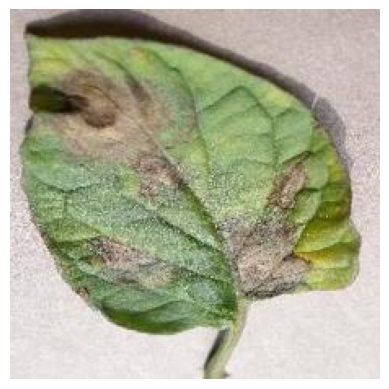

In [112]:

test_path = 'dataset/test/Late_blight227'
image_files = glob.glob(os.path.join(test_path,'*.jpg'))
# Select a random image file
random_image_file = random.choice(image_files)

# Load and display the random image using matplotlib
image = imread(random_image_file)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()


In [101]:
# Load model with trained weights
weight_path = 'artifacts/weights_basic_ef_b1.pth'
efnet_b1_v1 = load_model(weights_path=weight_path, num_classes=8, device=device, config=config) 

In [113]:
print('Image_name : ',random_image_file)
img_path = random_image_file
predict_single_image(image_path=img_path ,model=efnet_b1_v1, device='cuda')


Image_name :  dataset/test/Late_blight227/Lb324.jpg
Class late_blight: 0.99
Class leaf_mold: 0.01


_________

### **Further Work :**

- **Hyperparameter Tuning**: Optimize parameters like learning rate, batch size, input image size, drop out etc. Utilize techniques such as grid search or random search for efficient parameter exploration.

- **Different Augmentation Methods** : Experiment with relevant image augmentation techniques to increase the variability and size  of training data and improve model generalization.

- **Early Stopping and Learning Rate Scheduling** : Implement early stopping to prevent overfitting by monitoring validation performance. Utilize learning rate scheduling techniques to adjust learning rates dynamically during training for faster convergence.

- **Using Other Pre-trained Models and Comparing Results** : Fine-tune pre-trained models like VGG, AlexNet or EfficientNet on your dataset and compare their performance with custom CNN architectures to determine the most effective approach for your task.   Information about more [Pre-trained Models](https://pytorch.org/vision/stable/models.html)

_____________________________

In [53]:
# Get the total GPU memory
total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 2)  # in MB

# Get the current GPU memory usage
current_memory = torch.cuda.memory_allocated() / (1024 ** 2)  # in MB

# Calculate the unused GPU memory
unused_memory = total_memory - current_memory

print(f"Total GPU Memory: {total_memory:.2f} MB")
print(f"Current GPU Memory Usage: {current_memory:.2f} MB")
print(f"Unused GPU Memory: {unused_memory:.2f} MB")

Total GPU Memory: 3904.50 MB
Current GPU Memory Usage: 64.76 MB
Unused GPU Memory: 3839.74 MB


______________________